# Extracting features from SONATA Network simulations

This notebook shows how to extract features of a group of cells from a SONATA network, specifically focusing on a small portion of non-barrel primary somatosensory cortex circuit from juvenile rats, with the help of [BlueCellulLab](https://github.com/BlueBrain/BlueCelluLab/). For those interested in conducting a more in-depth analysis, the entire circuit dataset is accessible on [Zenodo](https://zenodo.org/records/8026353). For more details about the simulation and in-depth insights on the circuit, please refer to the Bluecellulab [SONATA Network example](https://github.com/BlueBrain/BlueCelluLab/blob/main/examples/2-sonata-network/sonata-network.ipynb) and the related [paper](https://www.biorxiv.org/content/10.1101/2023.05.17.541168v2.abstract), respectively.



**Note**: The compiled mechanisms need to be provided before importing bluecellulab.

In [ ]:
!nrnivmodl ./mechanisms

In [ ]:
import json
from pathlib import Path

from matplotlib import pyplot as plt

from bluecellulab import SSim
import efel

In this example, a small sub-circuit has been extracted from the [sscx circuit](https://zenodo.org/records/8026353). This sub-circuit specifically consists of a random selection of cells exhibiting delayed stuttering (dSTUT) etype. 

The simulation_config specifies the types of input stimuli to be applied to the cells. In this case, we have selected a 'relative_linear' stimulus of 70 ms and set the stimulus current at a level equivalent to 100 percent of the cell's threshold current.

In [3]:
simulation_config = Path("./") / "simulation_config.json"
with open(simulation_config) as f:
    simulation_config_dict = json.load(f)
print(json.dumps(simulation_config_dict, indent=4))

{
    "manifest": {
        "$OUTPUT_DIR": "."
    },
    "run": {
        "tstop": 100.0,
        "dt": 0.025,
        "random_seed": 1
    },
    "conditions": {
        "v_init": -65
    },
    "target_simulator": "NEURON",
    "network": "./O1/circuit_config.json",
    "node_set": "dSTUT_mini",
    "output": {
        "output_dir": "$OUTPUT_DIR/output_sonata",
        "spikes_file": "out.h5",
        "spikes_sort_order": "by_time"
    },
    "inputs": {
        "continuous_linear": {
            "input_type": "current_clamp",
            "module": "relative_linear",
            "delay": 20.0,
            "duration": 70.0,
            "percent_start": 100,
            "node_set": "dSTUT_mini"
        }
    },
    "reports": {
        "soma": {
            "cells": "dSTUT_mini",
            "variable_name": "v",
            "type": "compartment",
            "dt": 1.0,
            "start_time": 0.0,
            "end_time": 20.0,
            "sections": "soma",
            "compartmen

We use BlueCellulab for simulating smaller scale circuits, in contrast to the larger-scale simulations conducted with Neurodamus.

In [4]:
simulation_config = Path("./") / "simulation_config.json"
with open(simulation_config) as f:
    simulation_config_dict = json.load(f)
sim = SSim(simulation_config)

In [5]:
from bluepysnap import Simulation as snap_sim
snap_access = snap_sim(simulation_config)
import pandas as pd
from bluepysnap import Simulation as snap_sim
all_nodes = pd.concat([x[1] for x in snap_access.circuit.nodes.get()])
dstut_cells = all_nodes[all_nodes["etype"] == "dSTUT"].index.to_list()

In [6]:
sim.instantiate_gids(dstut_cells, add_stimuli=True)
t_stop = 100.0
sim.run(t_stop)

The plot displays the voltage traces simulated for each cell in our circuit.

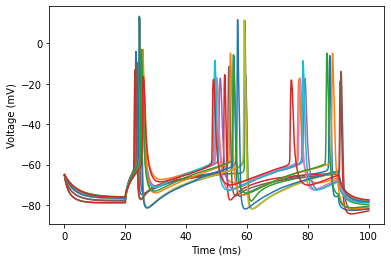

In [7]:
for cell_id in sim.cells:
    time = sim.get_time_trace()
    voltage = sim.get_voltage_trace(cell_id)
    plt.plot(time, voltage, label=cell_id)
    plt.xlabel("Time (ms)")
    plt.ylabel("Voltage (mV)")

Let's focus on 3 cells for better visualization

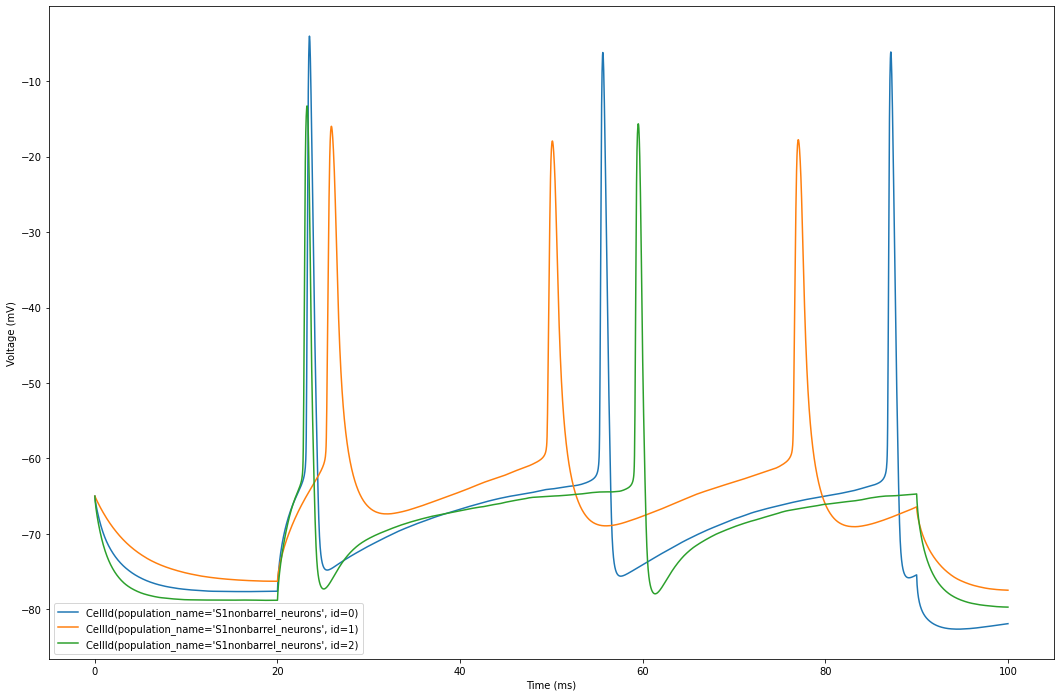

In [8]:
sim.cells = dict(list(sim.cells.items())[:3])
plt.figure(figsize=(18, 12))
for cell_id in sim.cells:
    time = sim.get_time_trace()
    voltage = sim.get_voltage_trace(cell_id)
    plt.plot(time, voltage, label=cell_id)
    plt.xlabel("Time (ms)")
    plt.ylabel("Voltage (mV)")
    plt.legend()

We are now ready to extract features. First, we will build the data structure for eFEL

In [9]:
traces = []
for cell_id in sim.cells:
    voltage = sim.get_voltage_trace(cell_id)
    trace = {}
    trace['T'] = time
    trace['V'] = voltage
    trace['stim_start'] = [20]
    trace['stim_end'] = [90]
    traces.append(trace)

Next, we choose the specific features of interest

In [10]:
features = ['peak_time', 'AHP_time_from_peak', 'AP_height', 'AHP_depth_abs']

Finally, we perform the feature extraction

In [11]:
traces_results = efel.get_feature_values(traces, features)

<ipython-input-11-164854ff5bf3>:1: DeprecationWarning: Use get_feature_values instead
  traces_results = efel.getFeatureValues(traces, features)


The plot below shows action potential (AP) height and depth of those 3 cells

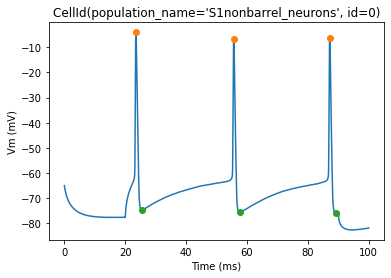

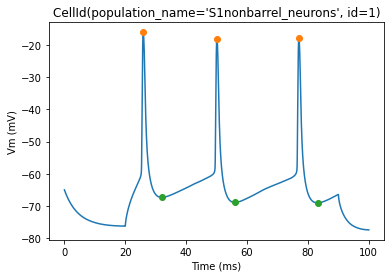

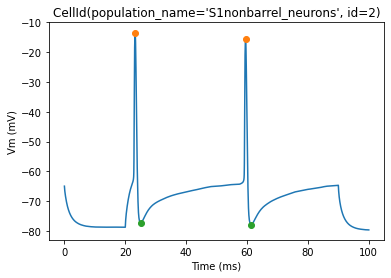

In [12]:
import pylab
for trace, trace_result, cell_id in zip(traces, traces_results, sim.cells):
    time = trace['T']
    voltage = trace['V']
    peak_times = trace_result['peak_time']
    ahp_time = trace_result['AHP_time_from_peak']
    ap_heights = trace_result['AP_height']
    AHP_depth_abss = trace_result['AHP_depth_abs']

    pylab.title(cell_id)
    pylab.plot(time,voltage)
    pylab.plot(peak_times, ap_heights, 'o')
    pylab.plot(peak_times+ahp_time, AHP_depth_abss, 'o')
    pylab.xlabel('Time (ms)')
    pylab.ylabel('Vm (mV)')
    pylab.show()